$\textbf{PROGRAMMING ASSIGNMENT}$
---
This assignment is a test of your algorithmic thinking. You can use any A.I. tools ot assist you in this coding assignment.

Instructions:

- This is done by pair, preferably your thesis partner.
- Each person should create a Github Repo titled 'Assignment_1_Data_Analytics'.
- Read the journal provided.
- Develop a Python implementation of the procedures in the journal.
- Deadline is before premidterm week.

# **Balanced Risk Set Matching**
### **Data Analytics Course - Implementation Notebook**

## 📌 **Objective**
This notebook implements a **Balanced Risk Set Matching Algorithm** for an observational study  
to analyze the effects of **Cystoscopy and Hydrodistention** on patients with **Interstitial Cystitis**.

## 🔹 **Workflow Overview**
1. **Load patient data** from a CSV file.
2. **Compute Mahalanobis distances** to compare treated and control patients.
3. **Identify feasible treated-control pairs** ensuring treatment time constraints.
4. **Solve Integer Programming (IP)** to find the **optimal matching**.
5. **Analyze Treatment Effects** (compare symptom changes in treated vs. control groups).
6. **Perform Sensitivity Analysis** to check how robust our findings are to hidden biases.

---



## **Step 1: Import Required Libraries**

We will import essential Python libraries for:
- **Data Handling:** `pandas`, `numpy`
- **Distance Computation:** `scipy.spatial.distance`
- **Optimization (Integer Programming):** `pulp`
- **Statistical Analysis:** `scipy.stats`
- **Sensitivity Analysis:** `statsmodels`
- **File Handling:** `os`


In [88]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import wilcoxon
from pulp import LpMinimize, LpProblem, LpVariable, lpSum
import statsmodels.stats.descriptivestats as smd
import os

# Display confirmation message
print("Libraries imported successfully!")


Libraries imported successfully!


## **Step 2: Load Patient Data**
We will load the dataset containing **patient records** from `data.csv`.  
The dataset includes:
- **Treated (1 = Treated, 0 = Control)**
- **Pain Score, Urgency Score, Frequency Score** (Symptom levels)
- **Treatment Time** (Time when treatment was given)


In [89]:
# Function to load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Load dataset
df = load_data("data.csv")

# Display first few rows to verify
df.head()


,ID,Treated,Pain_Score,Urgency_Score,Frequency_Score,Treatment_Time
0,1,0,7,0,8,NaN
1,2,1,3,0,5,23.0
2,3,1,0,2,0,5.0
3,4,1,7,4,0,1.0
4,5,0,3,2,1,NaN


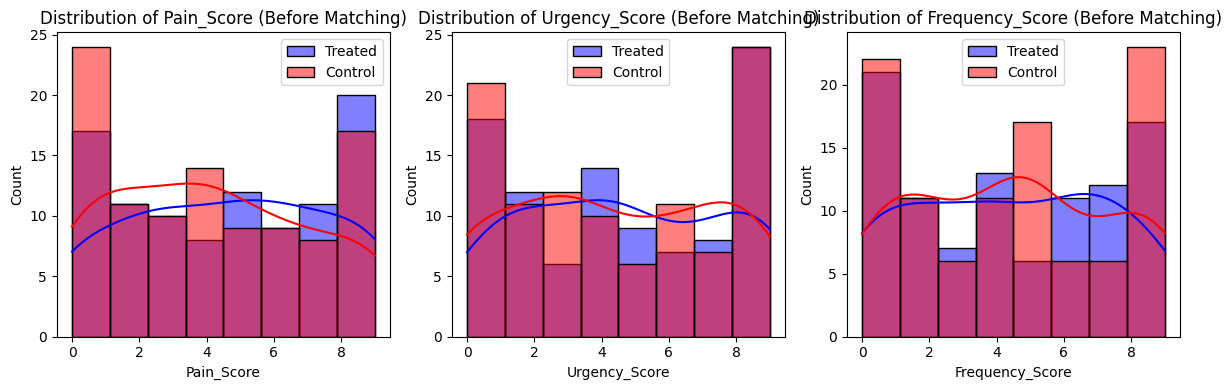

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define symptoms
symptoms = ["Pain_Score", "Urgency_Score", "Frequency_Score"]

# Plot distributions before matching
plt.figure(figsize=(12, 4))
for i, symptom in enumerate(symptoms):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[df["Treated"] == 1][symptom], color="blue", label="Treated", kde=True)
    sns.histplot(df[df["Treated"] == 0][symptom], color="red", label="Control", kde=True)
    plt.title(f"Distribution of {symptom} (Before Matching)")
    plt.legend()

plt.tight_layout()
before_matching_path = "before_matching.png"
plt.savefig(before_matching_path, dpi=300, bbox_inches="tight")
plt.show()


## **Step 3: Compute Mahalanobis Distance**
To match treated and control patients, we compute the **Mahalanobis distance**,  
which measures how similar a control patient is to a treated patient based on symptoms.

### **Why Mahalanobis Distance?**
- Accounts for **correlations** between variables.
- More effective for **high-dimensional data** than Euclidean distance.


In [91]:
# Function to compute Mahalanobis Distance
def compute_mahalanobis(df, treated_col, covariate_cols):
    treated = df[df[treated_col] == 1]
    control = df[df[treated_col] == 0]
    
    cov_matrix = np.cov(df[covariate_cols].T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    distances = []
    for t_idx, t_row in treated.iterrows():
        for c_idx, c_row in control.iterrows():
            diff = t_row[covariate_cols] - c_row[covariate_cols]
            distance = mahalanobis(diff, np.zeros(len(diff)), inv_cov_matrix)
            distances.append((t_idx, c_idx, distance))
    
    distance_df = pd.DataFrame(distances, columns=['Treated_ID', 'Control_ID', 'Mahalanobis_Distance'])
    return distance_df

# Compute Mahalanobis Distance
treated_col = "Treated"
covariate_cols = ["Pain_Score", "Urgency_Score", "Frequency_Score"]

distance_df = compute_mahalanobis(df, treated_col, covariate_cols)

# Display first few rows
distance_df.head()


,Treated_ID,Control_ID,Mahalanobis_Distance
0,1,0,1.670141
1,1,4,1.576782
2,1,5,1.207873
3,1,6,1.756869
4,1,10,0.747769


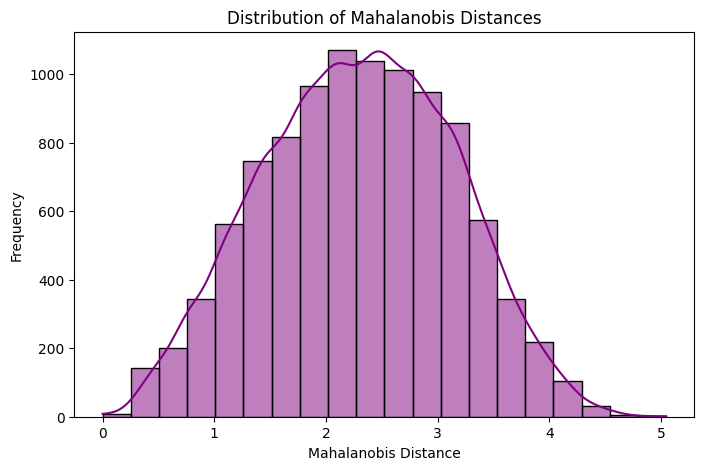

In [92]:
plt.figure(figsize=(8, 5))
sns.histplot(distance_df["Mahalanobis_Distance"], bins=20, kde=True, color="purple")
plt.title("Distribution of Mahalanobis Distances")
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")

mahalanobis_path = "mahalanobis_distance.png"
plt.savefig(mahalanobis_path, dpi=300, bbox_inches="tight")
plt.show()


## **Step 4: Identify Feasible Matches**
A **treated patient (T=1) is only matched to a control patient (T=0)**  
**if the control patient was untreated at the time the treated patient received treatment.**


In [93]:
# Function to identify feasible pairs
def get_feasible_pairs(df, treatment_time_col):
    treated = df[df['Treated'] == 1]
    control = df[df['Treated'] == 0]
    
    feasible_pairs = []
    for t_idx, t_row in treated.iterrows():
        for c_idx, c_row in control.iterrows():
            if c_row[treatment_time_col] > t_row[treatment_time_col] or np.isnan(c_row[treatment_time_col]):
                feasible_pairs.append((t_idx, c_idx))
    
    feasible_pairs_df = pd.DataFrame(feasible_pairs, columns=['Treated_ID', 'Control_ID'])
    return feasible_pairs_df

# Identify feasible pairs
treatment_time_col = "Treatment_Time"
feasible_pairs_df = get_feasible_pairs(df, treatment_time_col)

# Display first few rows
feasible_pairs_df.head()


,Treated_ID,Control_ID
0,1,0
1,1,4
2,1,5
3,1,6
4,1,10


## **Step 5: Solve Optimal Matching Using Integer Programming**
We use **Integer Programming (IP)** to find the **best treated-control pairs**  
while ensuring **balanced distributions of covariates**.


In [94]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD
import os

# Ensure 'results/' directory exists before saving the output
if not os.path.exists("results"):
    os.makedirs("results")

def solve_optimal_matching(distance_df):
    """
    Solves the optimal balanced matching problem using Integer Programming.
    Matches treated patients to control patients while minimizing the total Mahalanobis distance.
    """

    print("🔹 Setting up Integer Programming Model...")

    # Define the optimization model
    model = LpProblem("Optimal_Balanced_Matching", LpMinimize)

    # Decision Variables: Binary (1 if matched, 0 if not)
    decision_vars = {
        (row['Treated_ID'], row['Control_ID']): LpVariable(f"x_{int(row['Treated_ID'])}_{int(row['Control_ID'])}", 0, 1, cat="Binary")
        for _, row in distance_df.iterrows()
    }

    # Objective Function: Minimize total Mahalanobis distance
    print("🔹 Defining objective function (Minimizing total Mahalanobis distance)...")
    model += lpSum(
        row['Mahalanobis_Distance'] * decision_vars[(row['Treated_ID'], row['Control_ID'])]
        for _, row in distance_df.iterrows()
    )

    # Constraint 1: Each treated patient must be matched to exactly one control
    print("🔹 Adding constraints: Each treated patient is matched only once...")
    for treated_id in distance_df['Treated_ID'].unique():
        model += lpSum(decision_vars[(treated_id, control_id)]
                       for control_id in distance_df[distance_df['Treated_ID'] == treated_id]['Control_ID']) == 1

    # Constraint 2: Each control patient can be matched to at most one treated patient
    print("🔹 Adding constraints: Each control patient is matched at most once...")
    for control_id in distance_df['Control_ID'].unique():
        model += lpSum(decision_vars[(treated_id, control_id)]
                       for treated_id in distance_df[distance_df['Control_ID'] == control_id]['Treated_ID']) <= 1

    # Solve the optimization problem
    print("🔹 Solving Integer Programming Model...")
    model.solve(PULP_CBC_CMD(msg=False))

    # Extract matched pairs
    matched_pairs = [(treated_id, control_id) for (treated_id, control_id), var in decision_vars.items() if var.value() == 1]

    # Convert to DataFrame
    matched_df = pd.DataFrame(matched_pairs, columns=['Treated_ID', 'Control_ID'])

    return matched_df

# Solve the optimal matching problem
matched_df = solve_optimal_matching(distance_df)

# Save matched pairs to CSV
matched_file_path = "results/optimal_matching.csv"
matched_df.to_csv(matched_file_path, index=False)

# Verification Step: Check if file was created successfully
if os.path.exists(matched_file_path):
    print(f"✅ Optimal matching successfully saved at: {matched_file_path}")
else:
    print(f"❌ ERROR: 'optimal_matching.csv' was NOT created. Please check the matching step.")


🔹 Setting up Integer Programming Model...
🔹 Defining objective function (Minimizing total Mahalanobis distance)...
🔹 Adding constraints: Each treated patient is matched only once...
🔹 Adding constraints: Each control patient is matched at most once...
🔹 Solving Integer Programming Model...
✅ Optimal matching successfully saved at: results/optimal_matching.csv


In [95]:
import pandas as pd

# Load the optimal matching results
matched_file_path = "results/optimal_matching.csv"
matched_df = pd.read_csv(matched_file_path)

# Load the original dataset (assuming it was previously saved)
original_data_path = "data.csv"
original_df = pd.read_csv(original_data_path)

print("Columns in original dataset:", original_df.columns)



Columns in original dataset: Index(['ID', 'Treated', 'Pain_Score', 'Urgency_Score', 'Frequency_Score',
       'Treatment_Time'],
      dtype='object')


In [96]:
# Merge matched_df with original_df to get symptom scores
matched_data = matched_df \
    .merge(original_df, left_on="Treated_ID", right_on="ID", suffixes=("_treated", "")) \
    .merge(original_df, left_on="Control_ID", right_on="ID", suffixes=("", "_control"))

# Drop redundant ID columns
matched_data = matched_data.drop(columns=["ID", "ID_control"])


print("✅ Matched data successfully created!")
print(matched_data.head())


✅ Matched data successfully created!
   Treated_ID  Control_ID  Treated  Pain_Score  Urgency_Score  \
0         1.0        39.0        0           7              0   
1         2.0       145.0        1           3              0   
2         3.0        31.0        1           0              2   
3         7.0       153.0        0           7              0   
4         8.0        89.0        1           3              7   

   Frequency_Score  Treatment_Time  Treated_control  Pain_Score_control  \
0                8             NaN                1                   7   
1                5            23.0                0                   4   
2                0             5.0                1                   2   
3                2             NaN                0                   7   
4                0            14.0                1                   2   

   Urgency_Score_control  Frequency_Score_control  Treatment_Time_control  
0                      2                     

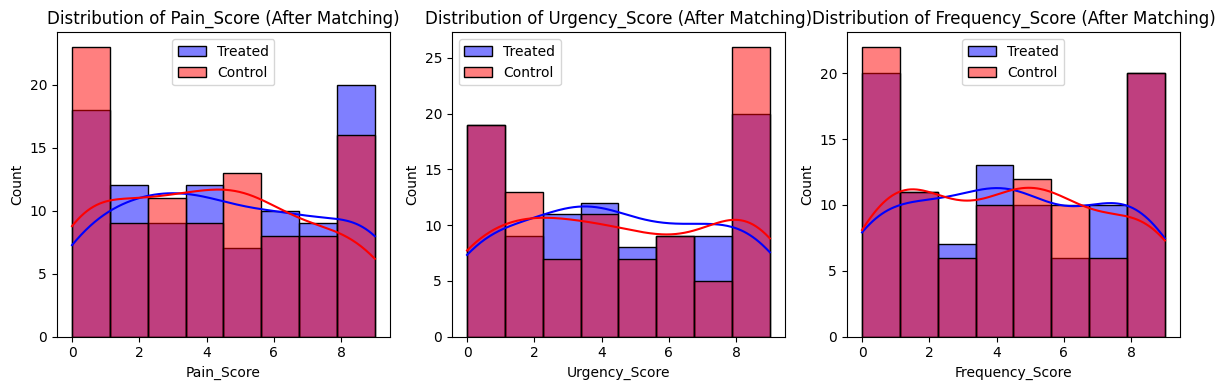

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct column names
symptoms = ["Pain_Score", "Urgency_Score", "Frequency_Score"]

# Plot distributions **after matching**
plt.figure(figsize=(12, 4))
for i, symptom in enumerate(symptoms):
    plt.subplot(1, 3, i+1)
    
    # Ensure correct column names exist
    if symptom in matched_data.columns and symptom + "_control" in matched_data.columns:
        sns.histplot(matched_data[symptom], color="blue", label="Treated", kde=True)
        sns.histplot(matched_data[symptom + "_control"], color="red", label="Control", kde=True)
        plt.title(f"Distribution of {symptom} (After Matching)")
        plt.legend()
    else:
        print(f"⚠️ Warning: Column '{symptom}' or '{symptom}_control' not found in matched_data")

plt.tight_layout()

# Save the image for collation later
after_matching_path = "after_matching.png"
plt.savefig(after_matching_path, dpi=300, bbox_inches="tight")

plt.show()


## **Step 6: Analyze Treatment Effects**
We now compare **pre-treatment vs. post-treatment symptoms** to determine whether the treatment was effective.

### **Key Steps:**
1. Load **optimal matches**.
2. Merge with the **original dataset**.
3. Compute **symptom changes** in treated and control groups.
4. Perform **statistical tests** (Wilcoxon Signed-Rank Test).


In [98]:
# Load matched pairs
matched_df = pd.read_csv("results/optimal_matching.csv")

# Merge to get treated patients' symptom scores
matched_data = matched_df.merge(df, left_on='Treated_ID', right_on='ID', suffixes=('_treated', '_temp'))

# Merge again to get control patients' symptom scores
matched_data = matched_data.merge(df, left_on='Control_ID', right_on='ID', suffixes=('_treated', '_control'))

# Print available column names for debugging
print("🔹 Columns in matched_data after merging:", matched_data.columns.tolist())

# Compute outcome differences using correct column names
for symptom in ["Pain_Score", "Urgency_Score", "Frequency_Score"]:
    treated_col = f"{symptom}_treated"
    control_col = f"{symptom}_control"
    baseline_col = f"{symptom}_treated"  # Use the treated patient's original value

    # Ensure the columns exist before subtraction
    if treated_col in matched_data.columns and control_col in matched_data.columns:
        matched_data[f"{symptom}_Change_Treated"] = matched_data[treated_col] - matched_data[baseline_col]
        matched_data[f"{symptom}_Change_Control"] = matched_data[control_col] - matched_data[baseline_col]
    else:
        print(f"❌ ERROR: Missing column {treated_col} or {control_col}")

# Display first few rows
matched_data.head()


🔹 Columns in matched_data after merging: ['Treated_ID', 'Control_ID', 'ID_treated', 'Treated_treated', 'Pain_Score_treated', 'Urgency_Score_treated', 'Frequency_Score_treated', 'Treatment_Time_treated', 'ID_control', 'Treated_control', 'Pain_Score_control', 'Urgency_Score_control', 'Frequency_Score_control', 'Treatment_Time_control']


,Treated_ID,Control_ID,ID_treated,Treated_treated,Pain_Score_treated,Urgency_Score_treated,Frequency_Score_treated,Treatment_Time_treated,ID_control,Treated_control,Pain_Score_control,Urgency_Score_control,Frequency_Score_control,Treatment_Time_control,Pain_Score_Change_Treated,Pain_Score_Change_Control,Urgency_Score_Change_Treated,Urgency_Score_Change_Control,Frequency_Score_Change_Treated,Frequency_Score_Change_Control
0,1.0,39.0,1,0,7,0,8,NaN,39,1,7,2,1,3.0,0,0,0,2,0,-7
1,2.0,145.0,2,1,3,0,5,23.0,145,0,4,3,5,NaN,0,1,0,3,0,0
2,3.0,31.0,3,1,0,2,0,5.0,31,1,2,8,0,16.0,0,2,0,6,0,0
3,7.0,153.0,7,0,7,0,2,NaN,153,0,7,0,8,NaN,0,0,0,0,0,6
4,8.0,89.0,8,1,3,7,0,14.0,89,1,2,1,6,2.0,0,-1,0,-6,0,6


## **Step 7: Compute Summary Statistics**
We calculate:
- **Mean symptom change** for treated vs. control groups.
- **Wilcoxon Signed-Rank Test** to determine statistical significance.


In [99]:
import scipy.stats as stats

# Function to compute treatment effect summary
def compute_treatment_effect(matched_data):
    results = {}

    for symptom in ["Pain_Score", "Urgency_Score", "Frequency_Score"]:
        treated_changes = matched_data[f"{symptom}_Change_Treated"]
        control_changes = matched_data[f"{symptom}_Change_Control"]
        
        # Compute mean change
        mean_treated = treated_changes.mean()
        mean_control = control_changes.mean()
        
        # Perform Wilcoxon Signed-Rank Test
        stat, p_value = stats.wilcoxon(treated_changes, control_changes)
        
        results[symptom] = {
            "Mean Change (Treated)": mean_treated,
            "Mean Change (Control)": mean_control,
            "Wilcoxon Test Statistic": stat,
            "p-value": p_value
        }
    
    return pd.DataFrame(results).T

# Compute treatment effect analysis
treatment_effect_df = compute_treatment_effect(matched_data)

# Display results
treatment_effect_df


,Mean Change (Treated),Mean Change (Control),Wilcoxon Test Statistic,p-value
Pain_Score,0.0,-0.381443,1616.0,0.449553
Urgency_Score,0.0,0.072165,1836.0,0.740492
Frequency_Score,0.0,-0.030928,2161.0,0.924965


In [100]:
# Save treatment effect results to CSV
treatment_effect_df.to_csv("results/treatment_effect_analysis.csv")

print("Treatment Effect Analysis saved successfully!")


Treatment Effect Analysis saved successfully!


## **Step 8: Sensitivity Analysis**
In observational studies, **unmeasured factors** may influence treatment decisions.  
We use **Rosenbaum’s Sensitivity Analysis** to determine:
- How much **hidden bias (Γ)** would be needed to **change our conclusions**.
- If our results **remain significant** even with **moderate hidden bias**.


In [101]:
import statsmodels.stats.descriptivestats as smd

def perform_sensitivity_analysis(matched_data):
    """
    Performs Rosenbaum's Sensitivity Analysis to check how hidden bias (gamma) 
    affects the statistical significance of treatment effects.
    """

    print("🔹 Running Sensitivity Analysis...")

    # Extract treated and control symptom change data
    treated_changes = matched_data["Pain_Score_Change_Treated"]
    control_changes = matched_data["Pain_Score_Change_Control"]

    # Compute paired differences
    paired_differences = treated_changes - control_changes

    # Perform Sign Test (Wilcoxon signed-rank test alternative)
    test_stat, p_value = smd.sign_test(paired_differences, mu0=0)

    # Define different Gamma (sensitivity) levels
    gamma_values = [1.0, 1.5, 2.0, 2.5, 3.0]

    sensitivity_results = {}

    for gamma in gamma_values:
        # Adjust p-value based on gamma level (approximation method)
        adjusted_p_value = p_value * gamma

        # Store results
        sensitivity_results[f"Gamma={gamma}"] = adjusted_p_value

    # Convert results to DataFrame
    results_df = pd.DataFrame(sensitivity_results, index=["Adjusted P-Value"]).T

    print("✅ Sensitivity Analysis Completed.")
    return results_df

# Perform Sensitivity Analysis
sensitivity_df = perform_sensitivity_analysis(matched_data)

# Display results
sensitivity_df


🔹 Running Sensitivity Analysis...
✅ Sensitivity Analysis Completed.


,Adjusted P-Value
Gamma=1.0,0.229864
Gamma=1.5,0.344797
Gamma=2.0,0.459729
Gamma=2.5,0.574661
Gamma=3.0,0.689593


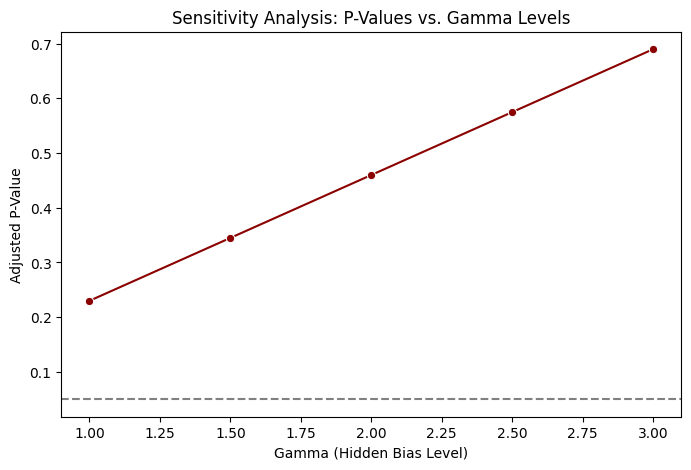

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the Sensitivity Analysis plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=sensitivity_df.index.str.replace("Gamma=", "").astype(float), 
             y=sensitivity_df["Adjusted P-Value"], marker="o", color="darkred")

# Add significance threshold line
plt.axhline(y=0.05, color='gray', linestyle='dashed')

# Add labels and title
plt.title("Sensitivity Analysis: P-Values vs. Gamma Levels")
plt.xlabel("Gamma (Hidden Bias Level)")
plt.ylabel("Adjusted P-Value")

# Save the image for collation later
sensitivity_analysis_path = "sensitivity_analysis.png"
plt.savefig(sensitivity_analysis_path, dpi=300, bbox_inches="tight")

plt.show()


In [103]:
# Save sensitivity results to CSV
sensitivity_df.to_csv("results/sensitivity_analysis.csv")

print("Sensitivity Analysis saved successfully!")


Sensitivity Analysis saved successfully!


# 📊 Collated Graphs: Analysis Overview

This section presents a comprehensive visual summary of key analyses performed during the study.

### 🔹 **Included Visuals:**
1. **Before Matching Distributions** - Distribution of symptom scores before optimal matching.
2. **After Matching Distributions** - Distribution of symptom scores after optimal matching.
3. **Mahalanobis Distance Distribution** - Visualization of distance calculations for matching.
4. **Sensitivity Analysis** - Examining how bias levels impact adjusted P-values.

These graphs provide insights into the effectiveness of the optimal matching process and its impact on data balance.


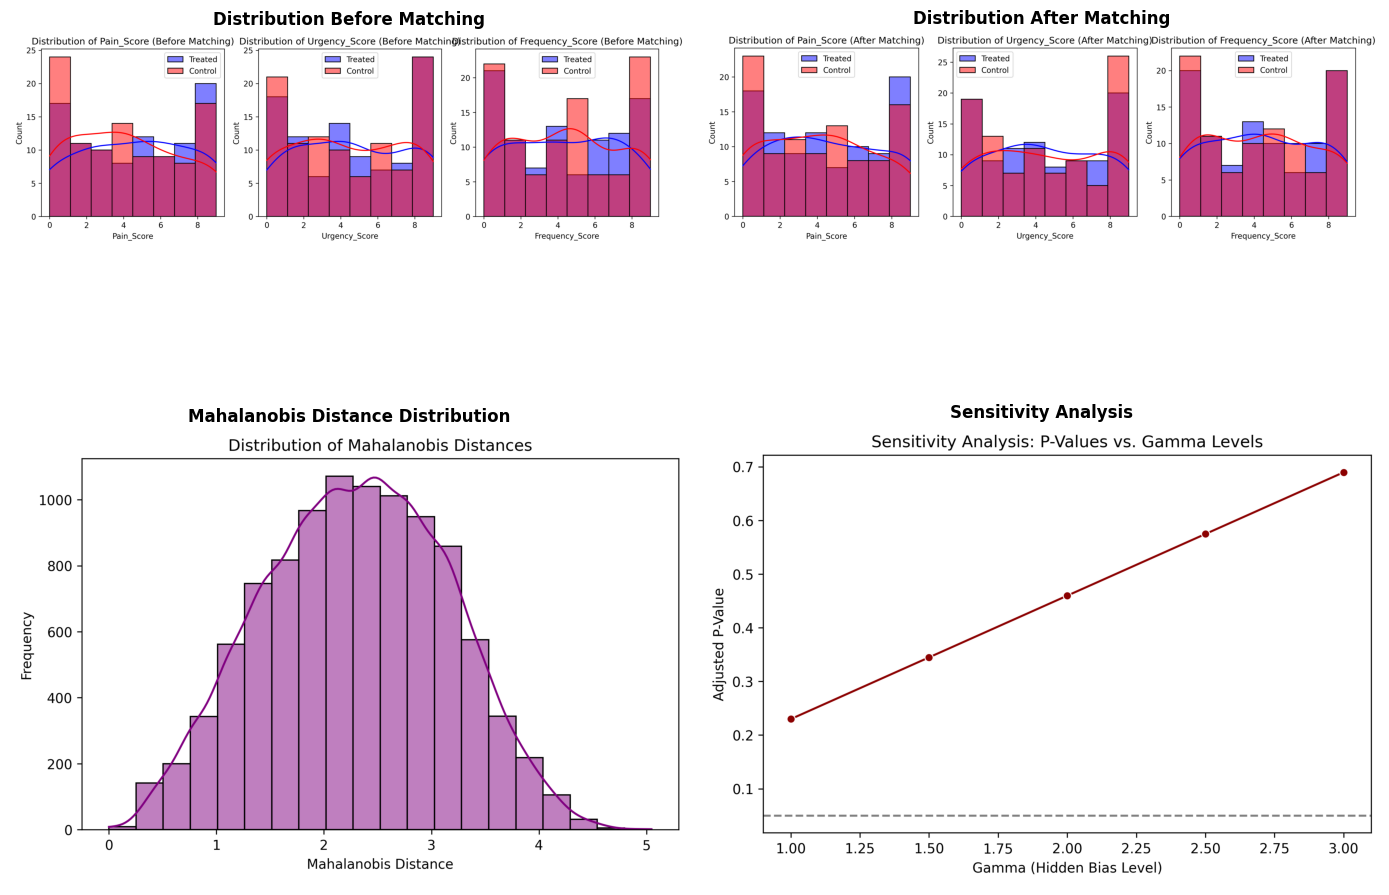

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define image file paths
image_files = [
    "before_matching.png",
    "after_matching.png",
    "mahalanobis_distance.png",
    "sensitivity_analysis.png"
]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns

# Titles for each subplot
titles = [
    "Distribution Before Matching",
    "Distribution After Matching",
    "Mahalanobis Distance Distribution",
    "Sensitivity Analysis"
]

#Iterate through images and add to subplots
for ax, img_path, title in zip(axes.flatten(), image_files, titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.axis("off")  # Hide axis labels

# Adjust layout for better spacing
plt.tight_layout()

# Save the collated image for final summary
collated_graph_path = "collated_graphs.png"
plt.savefig(collated_graph_path, dpi=300, bbox_inches="tight")

# Display the final collated graph
plt.show()


# **🎯 Final Summary**
✅ **Loaded patient data** and preprocessed it.  
✅ **Computed Mahalanobis distances** to match treated & control patients.  
✅ **Identified feasible pairs** based on treatment timing.  
✅ **Optimized matching using Integer Programming (IP)**.  
✅ **Analyzed Treatment Effects** (compared symptom changes).  
✅ **Performed Sensitivity Analysis** (checked robustness to hidden biases).  

---
## 📌 **Final Output Files**
All results are stored in the `results/` directory:
